## Correlation between the width of bump vs the correlation length, system size

In [1]:
import sys
import os
sys.path.append('Jerome_scripts_Original/PGM/')
sys.path.append('selfPackages/')
sys.path.append('Jerome_scripts_Original/')

import numpy as np
import scipy as sc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import rbm
    import bm
except:
    print 'Compiling cy_utilities first'
    curr_dir = os.getcwd()
    os.chdir('PGM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    
import pickle
from ising import IsingModel
import estimate_correlations_ising
from sklearn.utils import shuffle
import inlineMovies

In [13]:
def beta_from_corrLength(corrLen):
    beta = np.tan((np.exp(-1./corrLen)))
    return beta

In [18]:
#corrLengths = np.array([0.1,0.5,1.,5,10.,20.,50,100])
#corrLengths = np.array([2**0,2**1,2**2,2**3,2**4])
corrLengths = np.array([1,1.5,2,2.5,3])
beta = beta_from_corrLength(corrLengths)
print beta
print corrLengths

[ 0.38542559  0.5638536   0.69376726  0.79277524  0.87094952]
[ 1.   1.5  2.   2.5  3. ]


In [19]:
#Defining Parameters
Num_configs = 10000
Nstep       = beta*1000/1.5 #The number of Markov Chain steps for no correlation in the input data. This number was dec
                            # by checking the numebr of steps required for highest beta value which is 1000, which we scale further down.
N           = corrLengths*30 #The 30 factor was obtained by previous simulations where the system performed well with this sytems size
N           = N*0 + 30*3

print N

for i in np.arange(len(N)):
    N[i] = np.int(max(30,np.int(N[i]))) # We fix the minimum number of spins to 30

#Change the array type to int array from float array
N = N.astype(int)
Nstep = Nstep.astype(int)

[ 90.  90.  90.  90.  90.]


In [20]:
BM      = []
data    = []
results = []
RBM     = []

for i in np.arange(len(beta)):
    #Generate spins using Gibbs Sampling MCMC
    BM.append(bm.BM(N=N[i],nature='Spin'))

    #Define Couplings
    BM[i].layer.couplings =  beta[i]*(np.eye(N=N[i],k=1) + np.eye(N=N[i],k=-1) )
    BM[i].layer.couplings[0,-1] += beta[i]
    BM[i].layer.couplings[-1,0] += beta[i]
    
    #Generating the ising model data
    data.append(BM[i].gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=Nstep[i])) # N steps.

    #Train the model
    RBM.append(rbm.RBM(visible = 'Spin', n_v=N[i], n_h = 1, hidden = 'Spin',zero_field = True))
    results.append(RBM[i].fit(data[i],n_iter=250,verbose=0,learning_rate = 0.001,record=['W'],record_interval=100,batch_size=10,N_MC= 20, lr_decay=False,batch_norm=False))

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55
Starting epoch 56
S

Starting epoch 194
Starting epoch 195
Starting epoch 196
Starting epoch 197
Starting epoch 198
Starting epoch 199
Starting epoch 200
Starting epoch 201
Starting epoch 202
Starting epoch 203
Starting epoch 204
Starting epoch 205
Starting epoch 206
Starting epoch 207
Starting epoch 208
Starting epoch 209
Starting epoch 210
Starting epoch 211
Starting epoch 212
Starting epoch 213
Starting epoch 214
Starting epoch 215
Starting epoch 216
Starting epoch 217
Starting epoch 218
Starting epoch 219
Starting epoch 220
Starting epoch 221
Starting epoch 222
Starting epoch 223
Starting epoch 224
Starting epoch 225
Starting epoch 226
Starting epoch 227
Starting epoch 228
Starting epoch 229
Starting epoch 230
Starting epoch 231
Starting epoch 232
Starting epoch 233
Starting epoch 234
Starting epoch 235
Starting epoch 236
Starting epoch 237
Starting epoch 238
Starting epoch 239
Starting epoch 240
Starting epoch 241
Starting epoch 242
Starting epoch 243
Starting epoch 244
Starting epoch 245
Starting epo

Starting epoch 137
Starting epoch 138
Starting epoch 139
Starting epoch 140
Starting epoch 141
Starting epoch 142
Starting epoch 143
Starting epoch 144
Starting epoch 145
Starting epoch 146
Starting epoch 147
Starting epoch 148
Starting epoch 149
Starting epoch 150
Starting epoch 151
Starting epoch 152
Starting epoch 153
Starting epoch 154
Starting epoch 155
Starting epoch 156
Starting epoch 157
Starting epoch 158
Starting epoch 159
Starting epoch 160
Starting epoch 161
Starting epoch 162
Starting epoch 163
Starting epoch 164
Starting epoch 165
Starting epoch 166
Starting epoch 167
Starting epoch 168
Starting epoch 169
Starting epoch 170
Starting epoch 171
Starting epoch 172
Starting epoch 173
Starting epoch 174
Starting epoch 175
Starting epoch 176
Starting epoch 177
Starting epoch 178
Starting epoch 179
Starting epoch 180
Starting epoch 181
Starting epoch 182
Starting epoch 183
Starting epoch 184
Starting epoch 185
Starting epoch 186
Starting epoch 187
Starting epoch 188
Starting epo

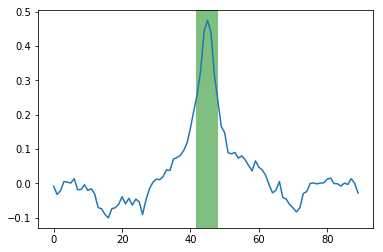

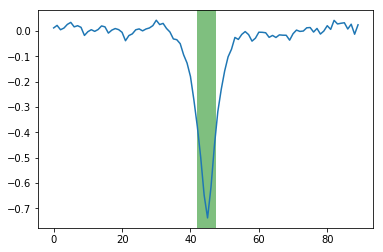

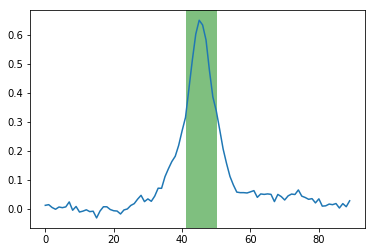

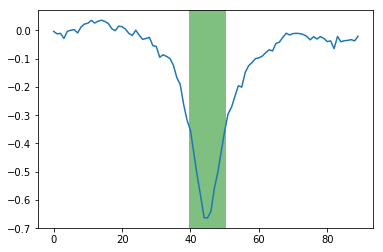

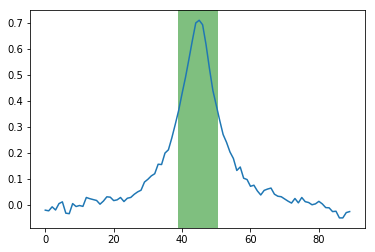

[6.5468299423610929, 5.6478970254060528, 9.0887655731474482, 10.896458136987285, 11.646224970384473]


In [21]:
# Fitting the Peak and calculating the width

from scipy.interpolate import UnivariateSpline
import pylab as pl

#Roll the array to put the peak in the centre
weightsAligned = []
spline = []
roots  = []
FWHM   = []

#for i in np.arange(len(beta)):
for i in np.arange(5):
    roll_val = -(np.argmax(abs(np.array(results[i]['W'])[-1,0,:])) - int(len(np.array(results[i]['W'])[-1,0,:])/2))
    weightsAligned.append(np.roll(np.array(results[i]['W'])[-1,0,:],roll_val))
    spline.append(UnivariateSpline(np.arange(len(np.array(results[i]['W'])[-1,0,:])),abs(weightsAligned[i])-np.max(abs(weightsAligned[i]))/2,s=0))
    roots.append(spline[i].roots())
    
    #Show the roots for visual verification
    pl.plot(np.arange(len(np.array(results[i]['W'])[-1,0,:])),weightsAligned[i])
    pl.axvspan(roots[i][0], roots[i][1], facecolor='g', alpha=0.5)
    pl.show()
    #I = input("Press Enter to continue...")
    
    FWHM.append(abs(roots[i][0]-roots[i][1]))
    
print FWHM
#plt.plot(np.array(results[1]['W'])[-1,0,:])

In [1]:
#Plot FWHM as a function of the correlation length

plt.scatter(corrLengths,FWHM)
plt.xlabel('Correlation Length')
plt.ylabel('Width of the peak (FWHM)')
plt.show()

NameError: name 'plt' is not defined

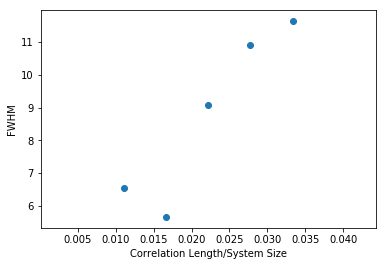

In [26]:
#Plot FWHM as a function of the correlation length/system size

plt.scatter((corrLengths.astype(float)/N),FWHM)
plt.xlabel('Correlation Length/System Size')
plt.ylabel('FWHM')
plt.show()